# Check data from hubs

checking ~113 badges in a single run. using 7 hubs
Testing ~113 new badges from the new batch

Most of  them have panasonic batteries. From #395 they have energizer
Set to scan every 15 seconds, for 3 seconds

Some badges were on so battery was lower
319, 413 were turn on late

Five hubs - 10,12,14,17, 18 ( 18 added late, it’s a pi zero) . Later I added 19 and 22 because I had issues with 10-17

Last unsync doesn’t always update the first time for some reason… not sure why. For example: 352, 347
(found it later, there wa a bug when reporting a observed_id > 32000)

In May 2, I had issues with pis 10,12,14,17. These are Pi 3’s, and for some reason when the hub code dies, they don’t restart the code well. I didn’t happen with the pi zero’s. I fixed part of it, but the data is probably acting funny

At some point, dev2 ran out of space. I had to download the logs for all hubs

Check - 
there was one badge which battery ran REALLY low, and then recovered. Look at the logs - did we hammer it somehow?
I think that pulling a lot of data every time drains the battery faster… so when we only had one hub, each time we pulled data we drained the batteries

In [1]:
#import sys
#!{sys.executable} -m pip install sklearn

In [2]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np

import pytz
import gzip

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

In [3]:
# Settings
time_zone = 'US/Eastern' # Your local timezone
hublog_time_zone = 'UTC'
log_version = '2.0'
time_bins_size = '15S' # For proximity scans

folder = '../data/raw/20180501_test_3v06_full_batch/'
proximity_filename = folder+'proximity_archive.txt.gz'
audio_filename = folder+'audio_archive.txt.gz'
hublog_filename = folder+'hub.log.gz'

In [4]:
# enables the %%R magic, not necessary if you've already done this
import readline
%load_ext rpy2.ipython 

%R -i time_zone timezone <- time_zone; print(timezone)

[1] "US/Eastern"


In [5]:
%%R
library(ggplot2)
library(scales)
rh_theme = theme(
    legend.title=element_text(size=2) , 
    legend.text=element_text(size=3)
    #panel.background=element_rect(fill="white"), # background=white
    #panel.grid.major.x=element_blank(), #no gridlines
    #panel.grid.minor.x=element_blank(), 
    #panel.grid.major.y=element_blank(), 
    #panel.grid.minor.y=element_blank(),
    #axis.text.x = element_text(angle=90, hjust = 1,vjust=1,size = 4,face = "bold"),
    #axis.text.y = element_text(size = 4)
)

# Load data

In [6]:
print("Loading voltage data (from proximity records)")
with gzip.open(proximity_filename, 'r') as f:
    voltages = ob.preprocessing.voltages(f, time_bins_size, tz=time_zone, skip_errors=True)

Loading voltage data (from proximity records)
('Error in line#:', 599607, '{"type": "proximity received", "log_timestamp": 1525253442.747, "data": {"timestamp": 1525253239.0, "rssi_distances": {"318": {"count": 1, "rssi": -44}, "338": {"count": 2, "rssi": -44}, "335": {"count": 3, "rssi": -44}, "333": {"count": 2, "rssi": -44}, "391": {"count": 2, "rssi": -44}, "413": {"count": 1, "rssi": -44}, "369": {"count": 2, "rssi": -44}, "407": {"count": 2, "rssi": -44}, "402": {"count": 1, "rssi": -44}, "324": {"count": 4, "rssi": -44}, "400": {"count": 2, "rssi": -44}, "367": {"count": 3, "rssi": -44}, "365": {"count": 3, "rssi": -44}, "349": {"count": 3, "rssi": -44}, "401": {"count": 2, "rssi": -44}, "302": {"count": 1, "rssi": -44}, "303": {"count{"type": "proximity received", "log_timestamp": 1525252134.635, "data": {"timestamp": 1525252107.0, "rssi_distances": {"311": {"count": 2, "rssi": -44}, "310": {"count": 3, "rssi": -44}, "317": {"count": 4, "rssi": -44}, "333": {"count": 3, "rssi":

KeyboardInterrupt: 

In [ ]:
print("Loading sample counts for proximity")
with gzip.open(proximity_filename, 'r') as f:
    proximity_sample_counts = ob.preprocessing.sample_counts(f, tz=time_zone, skip_errors=True)

print("Loading sample counts for audio")
with gzip.open(audio_filename, 'r') as f:
    audio_sample_counts = ob.preprocessing.sample_counts(f, tz=time_zone)


In [ ]:
print("Loading reset data")
with gzip.open(hublog_filename, 'r') as f:
    resets = ob.preprocessing.hublog_resets(f, log_tz = hublog_time_zone, tz=time_zone)

print("Loading clock sync data")
with gzip.open(hublog_filename, 'r') as f:
    clock_syncs = ob.preprocessing.hublog_clock_syncs(f, log_tz = hublog_time_zone, tz=time_zone)

In [24]:
# starting time
first_date = resets.index.get_level_values('datetime').min()
first_date

Timestamp('2018-05-01 16:44:38.337000-0400', tz='US/Eastern')

In [25]:
def to_relative_datetime(data):
    """ switch to relative time (since experiment started) """
    realtive_time = data.reset_index().copy()
    realtive_time['datetime'] = realtive_time['datetime'] - first_date
    realtive_time['day'] = realtive_time['datetime']/pd.Timedelta(days=1)
    return realtive_time

# Cleanup
Sometimes we get some records from the future or past. It's a bug, but it's so uncommon that we haven't found the reason yet


In [26]:
time_slice = slice('2018-01-01 00:00:00', '2018-05-10 00:00:00')

resets = resets.loc[time_slice, :]
voltages = voltages.loc[time_slice, :]

proximity_sample_counts.reset_index(level=1,inplace=True)
proximity_sample_counts = proximity_sample_counts.loc[time_slice, :]
proximity_sample_counts.set_index('member', append=True, inplace=True)

audio_sample_counts.reset_index(level=1,inplace=True)
audio_sample_counts = audio_sample_counts.loc[time_slice, :]
audio_sample_counts.set_index('member', append=True, inplace=True)

clock_syncs = clock_syncs.loc[time_slice, :]

# Split into two groups

In [27]:
import json
def mac_to_key_mapping(fileobject):
    def readfile(fileobject):
        i = 0
        for line in fileobject:
            i = i + 1
            try:
                data = json.loads(line)['data']
                yield (str(data['badge_address']),
                       str(data['member']))
            except:
                print("Error in line#:", i, line)
                continue
            
    df = pd.DataFrame(readfile(fileobject), columns=['mac', 'member'])
    df = df.groupby(['mac','member']).count().reset_index()
    return df

with gzip.open(proximity_filename, 'r') as f:
    mac_to_key = mac_to_key_mapping(f)

Error in line#: 599607 {"type": "proximity received", "log_timestamp": 1525253442.747, "data": {"timestamp": 1525253239.0, "rssi_distances": {"318": {"count": 1, "rssi": -44}, "338": {"count": 2, "rssi": -44}, "335": {"count": 3, "rssi": -44}, "333": {"count": 2, "rssi": -44}, "391": {"count": 2, "rssi": -44}, "413": {"count": 1, "rssi": -44}, "369": {"count": 2, "rssi": -44}, "407": {"count": 2, "rssi": -44}, "402": {"count": 1, "rssi": -44}, "324": {"count": 4, "rssi": -44}, "400": {"count": 2, "rssi": -44}, "367": {"count": 3, "rssi": -44}, "365": {"count": 3, "rssi": -44}, "349": {"count": 3, "rssi": -44}, "401": {"count": 2, "rssi": -44}, "302": {"count": 1, "rssi": -44}, "303": {"count{"type": "proximity received", "log_timestamp": 1525252134.635, "data": {"timestamp": 1525252107.0, "rssi_distances": {"311": {"count": 2, "rssi": -44}, "310": {"count": 3, "rssi": -44}, "317": {"count": 4, "rssi": -44}, "333": {"count": 3, "rssi": -44}, "393": {"count": 3, "rssi": -44}, "394": {"co

In [31]:
mac_to_key.head(5)

,mac,member
0,C0:FD:A1:67:A2:9C,X7D426CXNI
1,C1:10:19:FA:B5:B4,ZULVVJVABK
2,C1:1F:78:01:C5:0D,MCJ1JQ16KP
3,C1:5F:E7:20:36:70,4EC2OFVWLA
4,C1:74:43:BA:15:30,GYZ50W8JOQ


In [ ]:
type_a = [
#    'FF:89:FF:66:48:E6',
#    'C1:5F:E7:20:36:70',
#    'C5:0E:A8:0B:48:16',
#    'E1:5F:6D:4B:B1:15',
    ]

type_b = [
]

In [37]:
#mac_to_key_with_type = mac_to_key.copy()
#mac_to_key_with_type.loc[~mac_to_key_with_type.mac.isin(type_b),'type'] = 'b'
#mac_to_key_with_type.loc[mac_to_key_with_type.mac.isin(type_a),'type'] = 'a'
#mac_to_key_with_type.head()

In [39]:
#mac_to_key_with_type.describe()

In [29]:
members_full = pd.read_csv(folder+"Member-2018-05-06.csv")
members_full['type'] = members_full['id'].map(lambda x: 'a' if x >= 395 else 'b')
members_full.head(10)

# Voltage
Here we simply show the voltages of all the badges in the test. This helps us check how long they run and how fast the battery is deplated.

In [40]:
# Down sample
voltages_down = voltages.groupby([pd.TimeGrouper('300S', level='datetime'), 'member']).mean()

In [41]:
# Relative time
voltages_realtive_time = to_relative_datetime(voltages_down)

In [42]:
print(voltages_realtive_time.dtypes)
voltages_realtive_time.head()

datetime    timedelta64[ns]
member               object
voltage             float64
day                 float64
dtype: object


,datetime,member,voltage,day
0,-1 days +23:55:21.663000,24QMYF8JN1,3.090,-0.003221
1,-1 days +23:55:21.663000,4303J0WY1D,2.990,-0.003221
2,-1 days +23:55:21.663000,4V1GA5GNNE,3.060,-0.003221
3,-1 days +23:55:21.663000,6EKD7AXFA9,3.090,-0.003221
4,-1 days +23:55:21.663000,8G02JFKY6H,2.978,-0.003221


In [43]:
voltages_realtive_time = voltages_realtive_time.join(members_full.set_index('key')[['type']], on='member')
voltages_realtive_time.head(5)

,datetime,member,voltage,day,type
0,-1 days +23:55:21.663000,24QMYF8JN1,3.090,-0.003221,b
1,-1 days +23:55:21.663000,4303J0WY1D,2.990,-0.003221,b
2,-1 days +23:55:21.663000,4V1GA5GNNE,3.060,-0.003221,b
3,-1 days +23:55:21.663000,6EKD7AXFA9,3.090,-0.003221,b
4,-1 days +23:55:21.663000,8G02JFKY6H,2.978,-0.003221,b


In [69]:
a_only = voltages_realtive_time.query('type == "a"')
b_only = voltages_realtive_time.query('type == "b"')

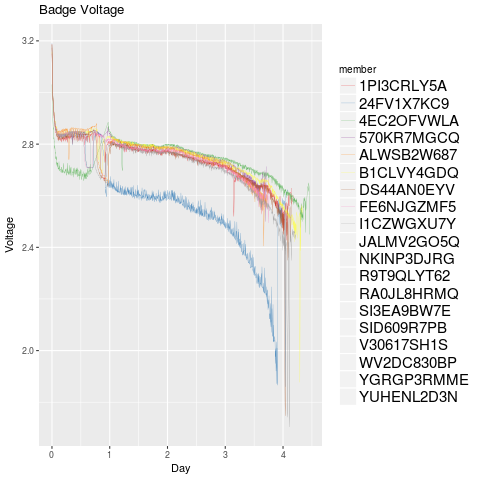

In [47]:
%%R -i a_only
data <- a_only
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = voltage, color =member)) +
    geom_line(size=0.1) +
    labs(title="Badge Voltage", x="Day", y="Voltage") +
    rh_theme +
    scale_colour_brewer(palette = "Set1") +
    theme(
        legend.title=element_text(size=10) ,
        legend.text=element_text(size=15)
        )

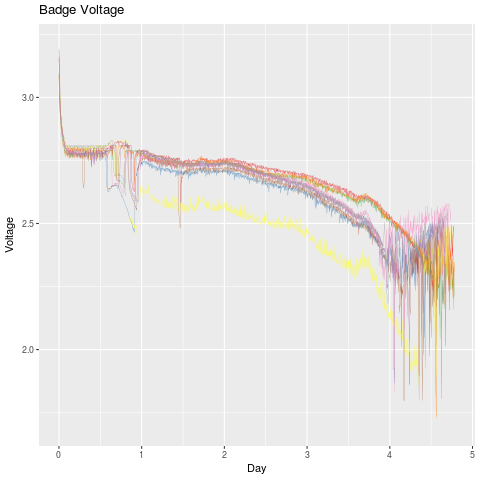

In [71]:
%%R -i b_only
data <- b_only
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = voltage, color =member)) +
    geom_line(size=0.1) +
    labs(title="Badge Voltage", x="Day", y="Voltage") +
    rh_theme +
    scale_colour_brewer(palette = "Set1") +
    theme(
        legend.title=element_text(size=10) ,
        legend.text=element_text(size=15),
        legend.position="none"
        )

In [48]:
'''
%%R -i voltages_realtive_time  -w 50 -h 80 --units in -r 200
data <- voltages_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = voltage, fill =member)) +
    geom_violin(size=0.1) +
    labs(title="Badge Voltage", x="Day", y="Voltage") +
    facet_wrap(~member, ncol = 5) +
    #rh_theme +
    scale_colour_brewer(palette = "Set1") 
    #theme(legend.position="none")
'''

'\n%%R -i voltages_realtive_time  -w 50 -h 80 --units in -r 200\ndata <- voltages_realtive_time\n#data$datetime <- as.POSIXct(data$datetime, tz = timezone)\n\nggplot(data, aes(x = day, y = voltage, fill =member)) +\n    geom_violin(size=0.1) +\n    labs(title="Badge Voltage", x="Day", y="Voltage") +\n    facet_wrap(~member, ncol = 5) +\n    #rh_theme +\n    scale_colour_brewer(palette = "Set1") \n    #theme(legend.position="none")\n'

# Resets
Here we look at "reset events" - when the hub sends the date the a badge, and the badge did not have a date set already. This means that the badge was either just turned on, or was reset. We expect to see a reset when the badge was first turned on, and we don't expect to see any resest until the voltages drop below 2.4v or so

In [52]:
resets_down = resets.copy()
resets_down['cnt'] = 1
resets_down = resets_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'mac']).count()
resets_down.head(1)

,,cnt
datetime,mac,
2018-05-01 16:30:00-04:00,C0:FD:A1:67:A2:9C,1


In [62]:
# switch to relative time (since experiment started)
resets_realtive_time = to_relative_datetime(resets_down)
resets_realtive_time.head()

,datetime,mac,cnt,day
0,-1 days +23:45:21.663000,C0:FD:A1:67:A2:9C,1,-0.010166
1,-1 days +23:45:21.663000,C1:10:19:FA:B5:B4,1,-0.010166
2,-1 days +23:45:21.663000,C1:1F:78:01:C5:0D,1,-0.010166
3,-1 days +23:45:21.663000,C1:5F:E7:20:36:70,1,-0.010166
4,-1 days +23:45:21.663000,C1:74:43:BA:15:30,1,-0.010166


In [63]:
#resets_realtive_time = resets_realtive_time.join(mac_to_key_with_type.set_index('mac'), on='mac')
resets_realtive_time = resets_realtive_time.join(members_full.set_index('badge')[['type']], on='mac')

In [66]:
resets_realtive_time_a_only = resets_realtive_time.query('type == "a"')
resets_realtive_time_b_only = resets_realtive_time.query('type == "b"')

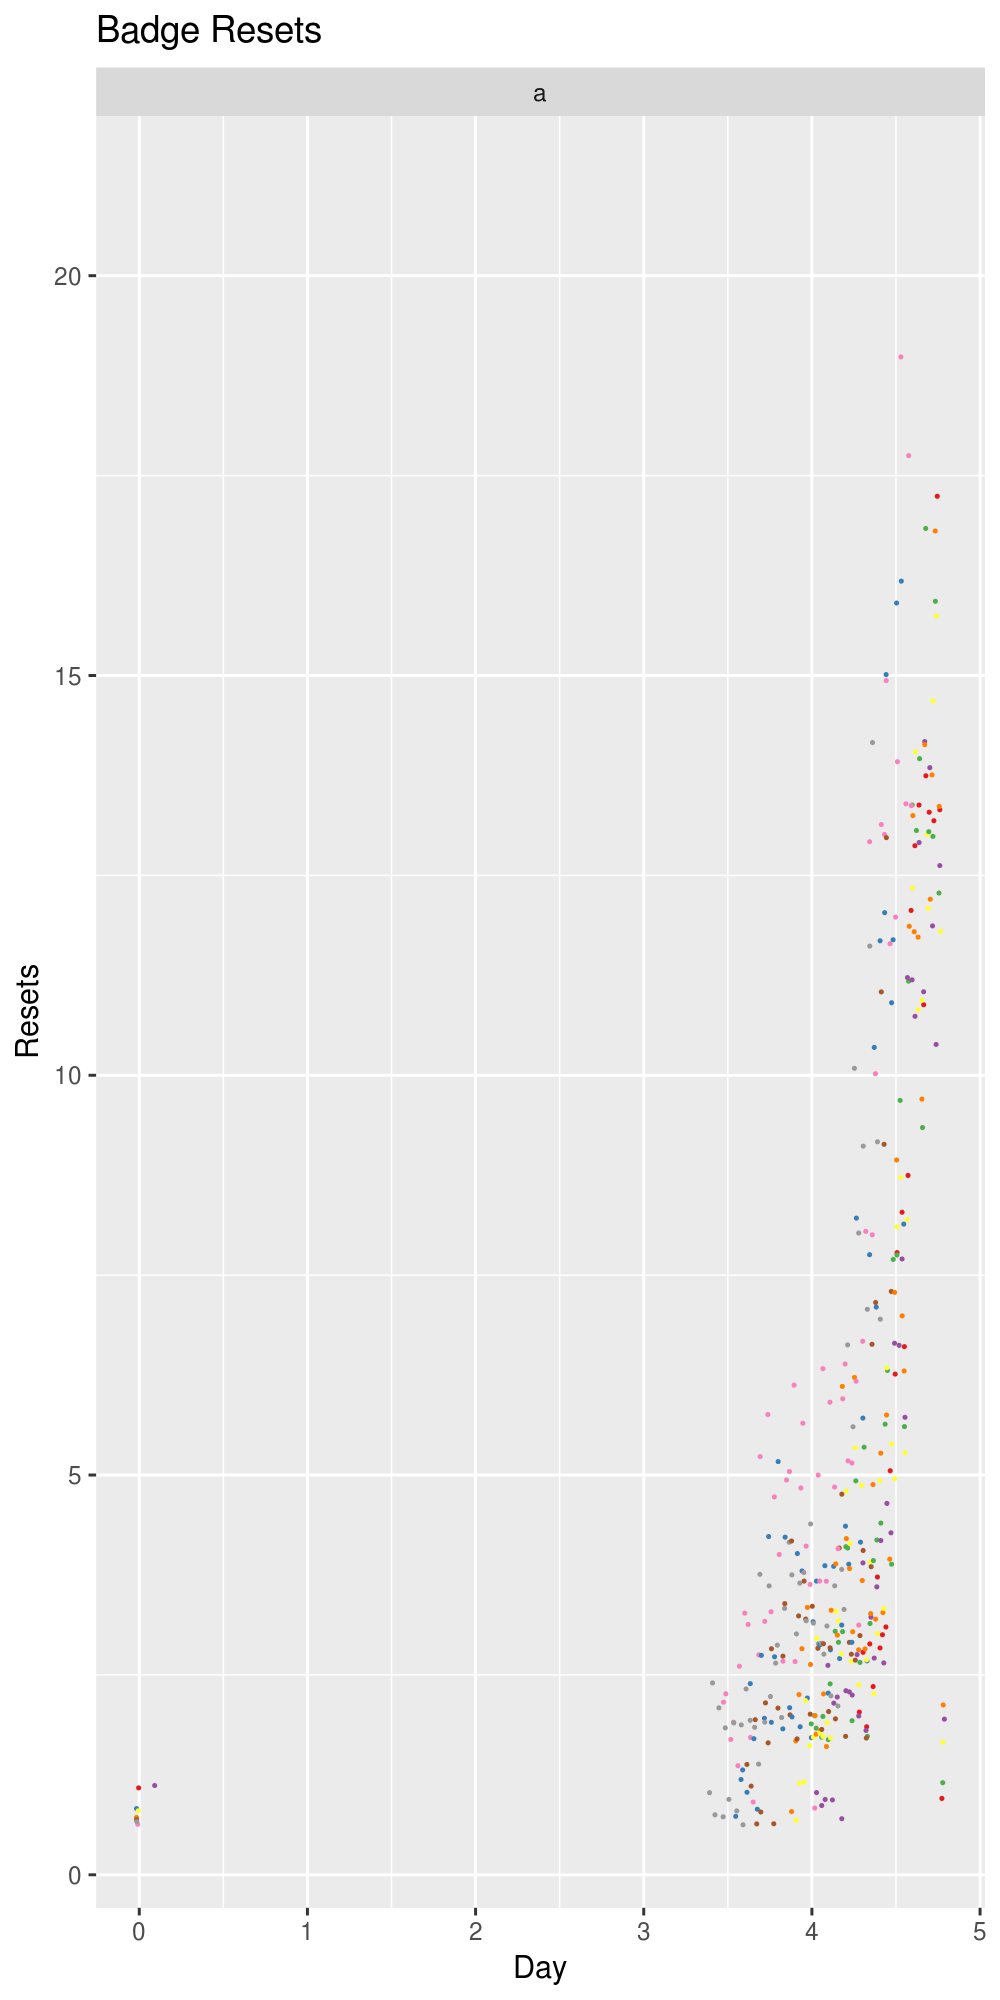

In [67]:
%%R -i resets_realtive_time_a_only -w 5 -h 10 --units in -r 200
data <- resets_realtive_time_a_only
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = cnt, color = mac)) +
    geom_point(size=0.2, position = "jitter") +
    labs(title="Badge Resets", x="Day", y="Resets") +
    facet_wrap(~type, nrow = 1) +
    rh_theme +
    scale_colour_brewer(palette = "Set1") +
    theme(legend.position="none")

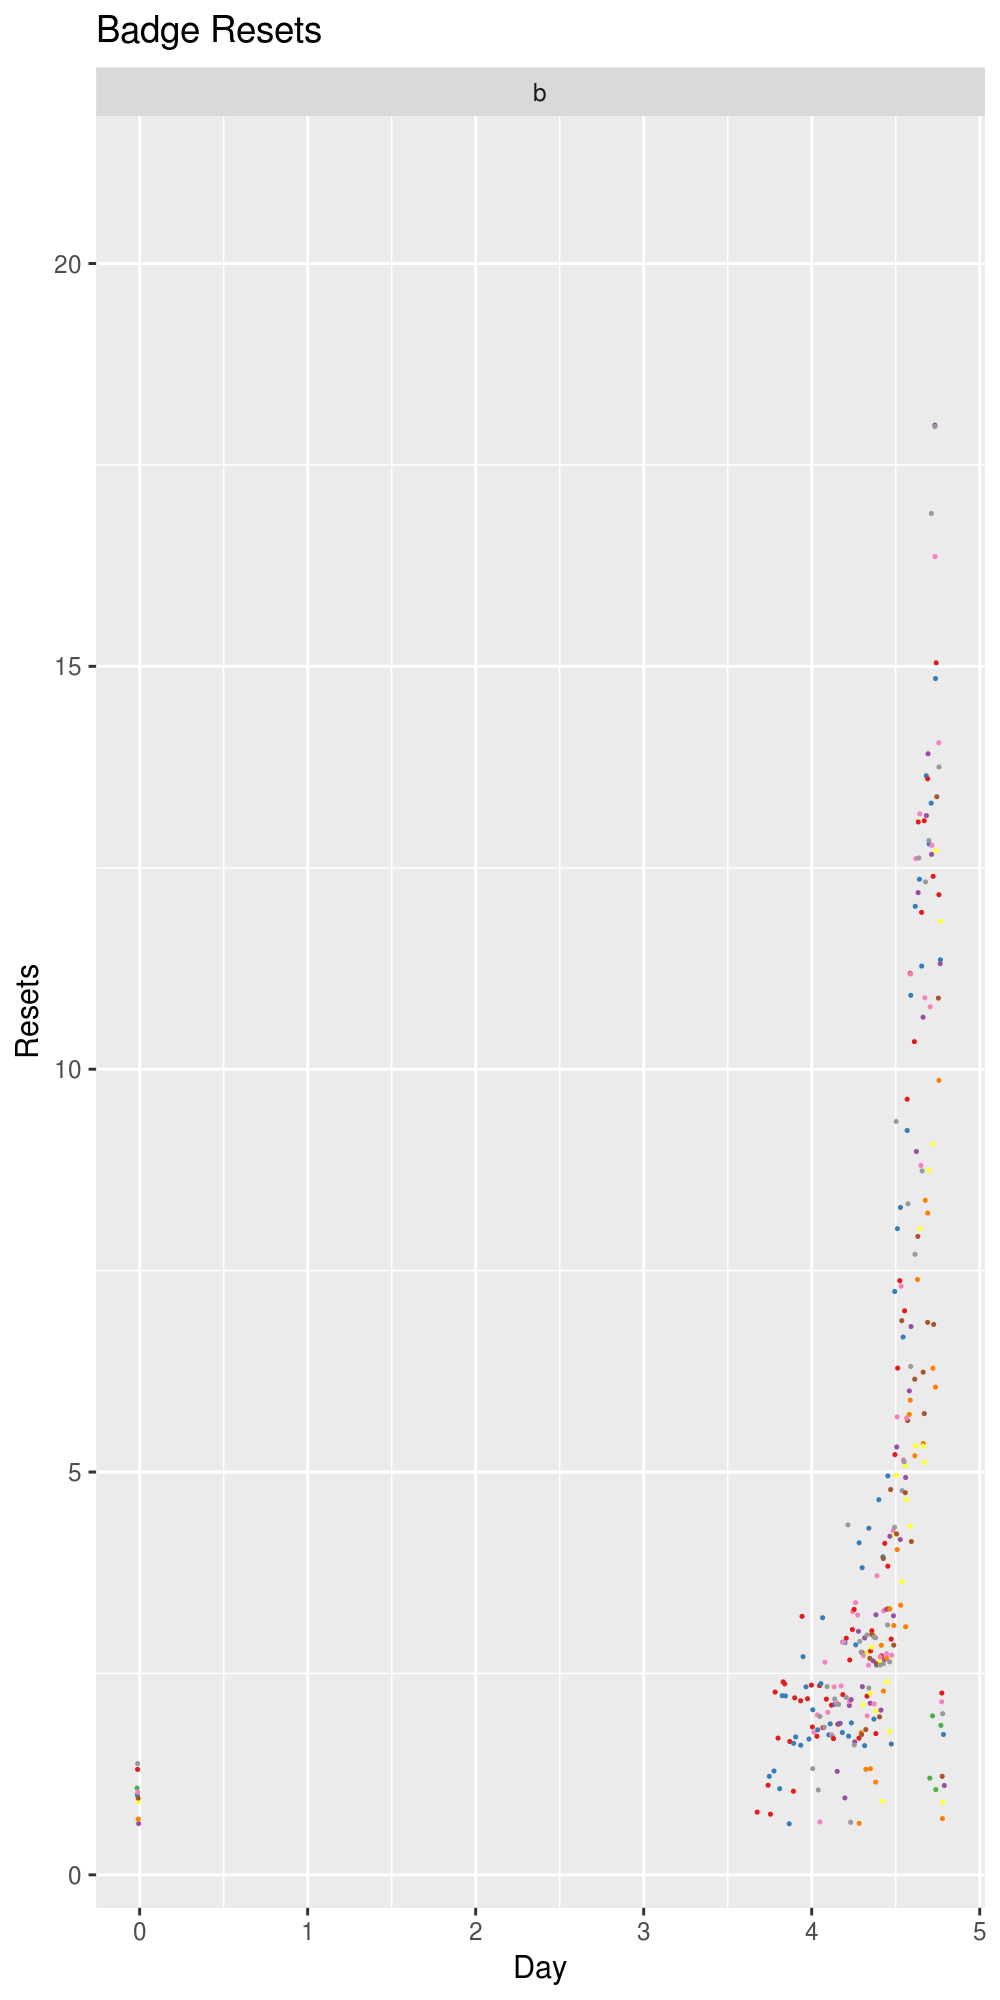

In [68]:
%%R -i resets_realtive_time_b_only -w 5 -h 10 --units in -r 200
data <- resets_realtive_time_b_only
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = cnt, color = mac)) +
    geom_point(size=0.2, position = "jitter") +
    labs(title="Badge Resets", x="Day", y="Resets") +
    facet_wrap(~type, nrow = 1) +
    rh_theme +
    scale_colour_brewer(palette = "Set1") +
    theme(legend.position="none")

# First resets
The first time a badge was reset (after starting)

In [56]:
df = pd.DataFrame([[1, np.nan], [1, 4], [5, 6]], columns=['A', 'B'])
g = df.groupby('A').nth(0)
df

,A,B
0,1,NaN
1,1,4.0
2,5,6.0


In [57]:
first_reset = resets.copy().reset_index()
first_reset = first_reset.groupby('mac').nth(1) # second reset. #0 is the first "reset" which is actually the first time the badge got a date from the server

In [72]:
first_reset.head(5)

,datetime
mac,
C0:FD:A1:67:A2:9C,2018-05-05 09:18:32.571000-04:00
C1:10:19:FA:B5:B4,2018-05-05 10:58:24.853000-04:00
C1:1F:78:01:C5:0D,2018-05-06 09:57:07.273000-04:00
C1:5F:E7:20:36:70,2018-05-05 23:41:58.345000-04:00
C1:74:43:BA:15:30,2018-05-05 20:44:02.129000-04:00


In [73]:
# switch to relative time (since experiment started)
first_reset_realtive_time = to_relative_datetime(first_reset)
first_reset_realtive_time.head()

,mac,datetime,day
0,C0:FD:A1:67:A2:9C,3 days 16:33:54.234000,3.690211
1,C1:10:19:FA:B5:B4,3 days 18:13:46.516000,3.759566
2,C1:1F:78:01:C5:0D,4 days 17:12:28.936000,4.717002
3,C1:5F:E7:20:36:70,4 days 06:57:20.008000,4.289815
4,C1:74:43:BA:15:30,4 days 03:59:23.792000,4.166248


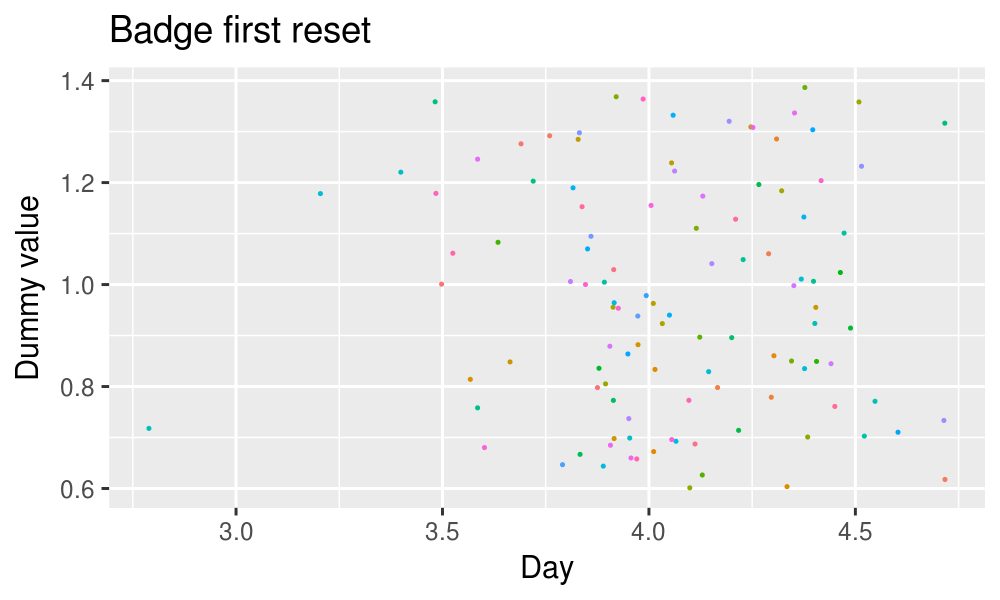

In [74]:
%%R -i first_reset_realtive_time -w 5 -h 3 --units in -r 200
data <- first_reset_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = 1, color = mac)) +
    geom_point(size=0.2, position = "jitter") +
    labs(title="Badge first reset", x="Day", y="Dummy value") +
    rh_theme +
    theme(legend.position="none")

# Proximity sample counts

In [ ]:
# Down sample
proximity_sample_counts_down = proximity_sample_counts.copy()
proximity_sample_counts_down = proximity_sample_counts_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'member']).mean()
proximity_sample_counts_down.head(1)

# switch to relative time (since experiment started)
proximity_sample_counts_realtive_time = to_relative_datetime(proximity_sample_counts_down)
proximity_sample_counts_realtive_time.head()

In [ ]:
%%R -i proximity_sample_counts_realtive_time -w 5 -h 80 --units in -r 200
data <- proximity_sample_counts_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = cnt, color =member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Proximity count", x="Day", y="Count") +
    rh_theme +
    theme(legend.position="none")

# Audio records count
For audio, we can't simply down sample. At least for the current version, we might get a "partial" record (less than 114 samples), and later the full version of the record. We'll therefore remove the duplications (using group by), and then resample and fill NaN with zeros in order to find gaps. We use a 10S window since every record represents 5.7 seconds of data, and we want to make sure not to create zero counts when there is no need to.

In [ ]:
audio_sample_counts_down = audio_sample_counts.copy()

In [ ]:
# Removing records so I can test what happens when there is missing data
#s = slice('2017-12-02 16:55:20', '2017-12-02 16:55:40')
#audio_sample_counts_down.drop(audio_sample_counts_down.loc[(s, slice(None), slice(None)), :].index, inplace=True)
#print(len(audio_sample_counts))
#print(len(audio_sample_counts_down))

In [ ]:
# If there are duplicates, choose the record with the most samples (that's a complete record)
audio_sample_counts_down = audio_sample_counts_down.groupby(['datetime', 'member']).max()

# Put 0's if there is missing data
audio_sample_counts_down = audio_sample_counts_down.unstack(level=[1]).resample('10S').min().fillna(0).stack(level=[1])

In [ ]:
# If removed records for testing, are there 0's there now?
#audio_counts_down.loc[(s, slice(None), slice(None)), :]

In [ ]:
# Down sample
audio_sample_counts_down = audio_sample_counts_down.unstack(level=[1]).resample('1min').min().stack(level=[1])
audio_sample_counts_realtive_time = audio_sample_counts_down.reset_index()

In [ ]:
%%R -i audio_sample_counts_realtive_time -w 5 -h 80 --units in -r 200
data <- audio_sample_counts_realtive_time
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = cnt, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Audio count", x="Day", y="Count") +
    rh_theme +
    theme(legend.position="none")

# Gaps in proximity data
Here we look for gaps in proximity data. We expect to see gaps of 60 seconds between scans (or less/more, depending on the settings used). If it's higher than that, then there's a gap.

In [ ]:
proximity_sample_counts_shift = proximity_sample_counts.copy().reset_index()
proximity_sample_counts_shift['lag_datetime'] = proximity_sample_counts_shift.groupby(['member'])['datetime'].shift(1)
proximity_sample_counts_shift['lag_datetime'] = proximity_sample_counts_shift['lag_datetime'].dt.tz_localize('UTC').dt.tz_convert(time_zone)
proximity_sample_counts_shift['time_diff_sec']= (proximity_sample_counts_shift['datetime']-proximity_sample_counts_shift['lag_datetime']) / np.timedelta64(1, 's')

# Down sample
proximity_sample_counts_shift.set_index('datetime', inplace=True)
proximity_sample_counts_shift_down = proximity_sample_counts_shift.groupby([pd.TimeGrouper('30min', level='datetime'), 'member']).max()

# switch to relative time (since experiment started)
proximity_sample_counts_shift_realtive_time = to_relative_datetime(proximity_sample_counts_shift_down)
proximity_sample_counts_shift_realtive_time.head()

In [ ]:
%%R -i proximity_sample_counts_shift_realtive_time -w 5 -h 80 --units in -r 200
data <- proximity_sample_counts_shift_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = time_diff_sec, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Gaps in proximity data", x="Day", y="Time diff (Sec)") +
    scale_y_continuous(limits = c(0, 180)) +
    rh_theme +
    theme(legend.position="none")

# Gaps in audio data
Here we look for gaps in audio data. We expect to see gaps of 5.7 seconds between records (each record represents 114 samples of 50 ms each). If it's higher than that, then there's a gap.

In [ ]:
audio_sample_counts_shift = audio_sample_counts.copy().reset_index()
audio_sample_counts_shift['lag_datetime'] = audio_sample_counts_shift.groupby(['member'])['datetime'].shift(1)
audio_sample_counts_shift['lag_datetime'] = audio_sample_counts_shift['lag_datetime'].dt.tz_localize('UTC').dt.tz_convert(time_zone)
audio_sample_counts_shift['time_diff_sec']= (audio_sample_counts_shift['datetime']-audio_sample_counts_shift['lag_datetime']) / np.timedelta64(1, 's')

# Down sample
audio_sample_counts_shift.set_index('datetime', inplace=True)
audio_sample_counts_shift_down = audio_sample_counts_shift.groupby([pd.TimeGrouper('30min', level='datetime'), 'member']).max()

# switch to relative time (since experiment started)
audio_sample_counts_shift_realtive_time = to_relative_datetime(audio_sample_counts_shift_down)
audio_sample_counts_shift_realtive_time.head()

In [ ]:
%%R -i audio_sample_counts_shift_realtive_time -w 5 -h 80 --units in -r 200
data <- audio_sample_counts_shift_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = time_diff_sec, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    #scale_y_continuous(limits = c(0, 60)) +
    labs(title="Gaps in audio data", x="Day", y="Time diff (sec)") +
    rh_theme +
    theme(legend.position="none")

# Comparing badge time to hub time
Here, we look at event where we send time from the hub to the badge. On each event, the badge reports back its internal time

In [ ]:
clock_syncs.head()

In [ ]:
# Down sample
clock_syncs_down = clock_syncs.copy().reset_index()
clock_syncs_down['clock_diff']=(clock_syncs_down['datetime']-clock_syncs_down['badge_datetime'])/pd.Timedelta(milliseconds=1)

clock_syncs_down.set_index(['datetime','mac'], inplace=True)
clock_syncs_down = clock_syncs_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'mac'])['clock_diff'].max().to_frame()
clock_syncs_down.reset_index(inplace=True)

In [ ]:
clock_syncs_down.head(5)

In [ ]:
%%R -i clock_syncs_down -w 5 -h 80 --units in -r 200
data <- clock_syncs_down
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = clock_diff, color = mac)) +
    geom_line(size=0.2) +
    facet_wrap( ~ mac, ncol=1)+
    labs(title="Time difference between hub and badge", x="Day", y="Clock diff (ms)") +
    rh_theme +
    theme(legend.position="none") +
    ylim(0, 500)
